## Working with OOI Data

In this example we will learn how to programatically download and work with OOI data from within the notebook. We will use data from the 3D Thermistory Array deployed in the ASHES Vent field at Axial Seamount for this example, but the mechanics apply to all datasets that are processed through the OOI Cyberinfrastructure (CI) system. You wil learn:

* how to find the data you are looking for
* how to use the machine to machine API to requestdata
* how to load the data into your notebook, once the data request has completed
* how to explore and plot data

### Part One: Finding and requesting the data.

In [1]:
import requests
import time

The ingredients being used to build the data_request_url can be found here. For this example, we will use the data from the 3D Thermistor Array (TMPSF)
http://ooi.visualocean.net/instruments/view/RS03ASHS-MJ03B-07-TMPSFA301

In [2]:
subsite = 'RS03ASHS'
node = 'MJ03B'
sensor = '07-TMPSFA301'
method = 'streamed'
stream = 'tmpsf_sample'
beginDT = '2014-09-27T01:01:01.000Z'
# endDT = '2017-08-01T01:01:01.000Z' # optional

Login in at https://ooinet.oceanobservatories.org/ and obtain your username and token under your profile (top right corner).

In [3]:
username =''
token = ''
base_url = 'https://ooinet.oceanobservatories.org/api/m2m/12576/sensor/inv/'

In [4]:
data_request_url = base_url+subsite+'/'+node+'/'+sensor+'/'+method+'/'+stream+'?beginDT='+beginDT
# data_request_url = base_url+subsite+'/'+node+'/'+sensor+'/'+method+'/'+stream+'?beginDT='+beginDT+'&endDT='+endDT
r = requests.get(data_request_url, auth=(username, token))
data = r.json()

The first url in the response is the location on THREDDS where the data is being served. We will get back to using the THREDDS location later.

In [5]:
print(data['allURLs'][0])

https://opendap.oceanobservatories.org/thredds/catalog/ooi/friedrich.knuth@rutgers.edu/20180129T235404-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/catalog.html


The second url in the response is the regular APACHE server location for the data.

In [6]:
print(data['allURLs'][1])

https://opendap.oceanobservatories.org/async_results/friedrich.knuth@rutgers.edu/20180129T235404-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample


We will use this second location to programatically check for a status.txt file to be written, containing the text 'request completed'. This indicates that the request is completed and the system has finished writing out the data to this location.

In [7]:
%%time
check_complete = data['allURLs'][1] + '/status.txt'
for i in range(1800): 
    r = requests.get(check_complete)
    if r.status_code == requests.codes.ok:
        print('request completed')
        break
    else:
        time.sleep(1)

request completed


## Part Two: Loading the data into the notebook.

In [8]:
from thredds_crawler.crawl import Crawl
import xarray as xr
import pandas as pd
import os

Start by using thredds_crawler to get a list of the NetCDF files on THREDDS. Note that seperate NetCDF files are created at 500 mb intervals and when there is a new deployment.

In [9]:
url = data['allURLs'][0]
url = url.replace('.html', '.xml')
tds_url = 'https://opendap.oceanobservatories.org/thredds/dodsC'
c = Crawl(url, select=[".*\.nc$"], debug=False)
datasets = [os.path.join(tds_url, x.id) for x in c.datasets]

In [10]:
datasets

['https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20180129T235404-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0003_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20170815T003130.804600-20180129T235351.436785.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20180129T235404-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20160829T000001.097642-20170813T232226.349596.nc',
 'https://opendap.oceanobservatories.org/thredds/dodsC/ooi/friedrich.knuth@rutgers.edu/20180129T235404-RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample/deployment0001_RS03ASHS-MJ03B-07-TMPSFA301-streamed-tmpsf_sample_20140929T190312-20160828T235949.096897.nc']

Use xarray to open all netcdf files as a single xarray datase, swap the dimention from obs to time and and examine the content.

In [11]:
ds = xr.open_mfdataset(datasets)
ds = ds.swap_dims({'obs': 'time'})
ds

<xarray.Dataset>
Dimensions:              (time: 10617951)
Coordinates:
    obs                  (time) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 ...
  * time                 (time) datetime64[ns] 2017-08-15T00:31:30.804600320 ...
    lat                  (time) float64 dask.array<shape=(10617951,), chunksize=(1435701,)>
    lon                  (time) float64 dask.array<shape=(10617951,), chunksize=(1435701,)>
Data variables:
    deployment           (time) int32 dask.array<shape=(10617951,), chunksize=(1435701,)>
    id                   (time) |S64 dask.array<shape=(10617951,), chunksize=(1435701,)>
    battery_voltage      (time) float64 dask.array<shape=(10617951,), chunksize=(1435701,)>
    driver_timestamp     (time) datetime64[ns] dask.array<shape=(10617951,), chunksize=(1435701,)>
    ingestion_timestamp  (time) datetime64[ns] dask.array<shape=(10617951,), chunksize=(1435701,)>
    internal_timestamp   (time) datetime64[ns] dask.array<shape=(10617951,), chunksize=(1435701,)>

## Part Three: Exploring the data.

In [17]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import numpy as np

Use built in xarray plotting functions to create simple line plot.

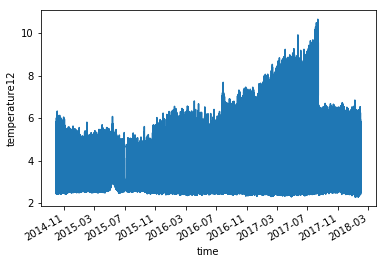

In [13]:
ds['temperature12'].plot()
plt.show()

We can tell that the peak temperature is increatsing, but this simple line plot does not reveal the internal data distribution. Let's convert to pandas dataframe and downsample from 1 Hz to 1/60 Hz

In [14]:
%%time
df = ds.to_dataframe()
df = df.resample('min').mean()

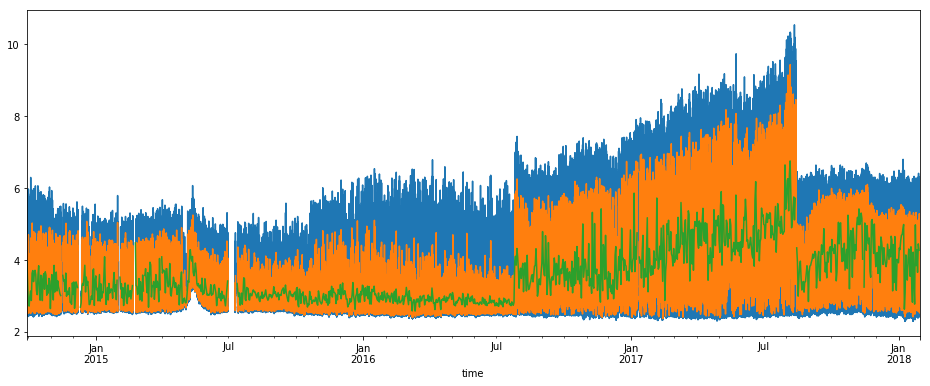

In [15]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)
df['temperature12'].plot(ax=ax)
df['temperature12'].resample('H').mean().plot(ax=ax)
df['temperature12'].resample('D').mean().plot(ax=ax)
plt.show()

Now we are getting a better sense of the data. Let's convert time to ordinal, grab temperature values and re-examine using hexagonal bi-variate binning.

In [18]:
timestamp = []
timestamp_pd = pd.to_datetime(ds.time.values.tolist())
for i in timestamp_pd:
    i = np.datetime64(i).astype(datetime.datetime)
    timestamp.append(dates.date2num(i)) 

In [20]:
temp_value = ds['temperature12'].values.tolist()

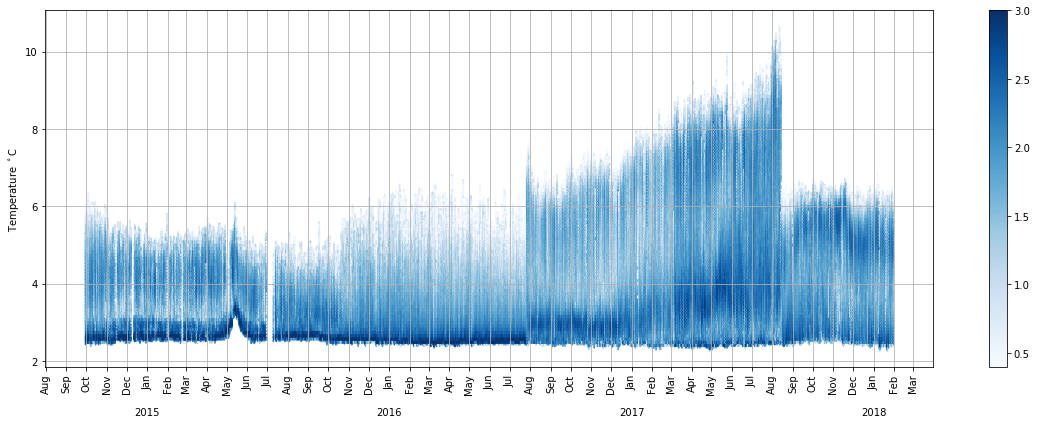

In [28]:
plt.close()
fig, ax = plt.subplots()
fig.set_size_inches(16, 6)

hb1 = ax.hexbin(timestamp, temp_value, bins='log', vmin=0.4, vmax=3, gridsize=(1100, 100), mincnt=1, cmap='Blues')
fig.colorbar(hb1)
ax.yaxis.grid(True)
ax.xaxis.grid(True)
# ax.set_xlim(datetime.datetime(2015, 12, 1, 0, 0),datetime.datetime(2016, 7, 25, 0, 0))
# ax.set_ylim(2,11)
years = dates.YearLocator()
months = dates.MonthLocator()
yearsFmt = dates.DateFormatter('\n\n\n%Y')
monthsFmt = dates.DateFormatter('%b')
ax.xaxis.set_major_locator(months)
ax.xaxis.set_major_formatter(monthsFmt)
ax.xaxis.set_minor_locator(years)
ax.xaxis.set_minor_formatter(yearsFmt)
plt.tight_layout()
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.ylabel('Temperature $^\circ$C')
plt.show()